# Two Layer VGG on MNIST

In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install matplotlib
!pip3 install numpy

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     -- ------------------------------------- 0.4/6.2 MB 11.2 MB/s eta 0:00:01
     -------- ------------------------------- 1.3/6.2 MB 16.4 MB/s eta 0:00:01
     ------------------ --------------------- 2.8/6.2 MB 22.3 MB/s eta 0:00:01
     -------------------------- ------------- 4.1/6.2 MB 23.9 MB/s eta 0:00:01
     ----------------------------------- ---- 5.5/6.2 MB 25.3 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 24.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ------------------------------------- 536.2/536.2 kB 32.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ---------------------------------------- 59.7/59.7 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   -------------------


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\adamy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/103.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/103.3 kB ? eta -:--:--
     --------------- ------------------------ 41.0/103.3 kB ? eta -:--:--
     ----------------------- --------------- 61.4/103.3 kB 3.2 MB/s eta 0:00:01
     ------------------------------------ 103.3/103.3 kB 989.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
    --------------------------------------- 0.1/8.0 MB 3.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/8.0 MB 12.6 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/8.0 MB 19.3 MB/s eta 0:00:01
   ------------------ --------------------- 3.8/8.0 MB 22.0 MB/s eta 0:00:01
   ----------------------- ---------------- 4.8/8.0 MB 23.4 MB/s eta 0:00:01
   ---------------------------- ----------- 5.7/8.0 MB 22.7 MB/s eta 0:00:01
   ---------------------------------- ----- 7.0/8.0 MB 22.2 MB/s eta 0:00:01
   ----------


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\adamy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\adamy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import Packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

##

### Define Model, and Load Dataset

In [4]:
# Define the VGG-like model
class VGG2Layer(nn.Module):
    def __init__(self):
        super(VGG2Layer, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


### Initialize model, loss function, and optimizer

In [5]:
# Initialize the model, loss function, optimizer, and epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG2Layer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

### Train Model and Evaluate Accuracy

In [6]:
# Training and validation

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

# Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/10, Loss: 0.1182, Train Accuracy: 96.35%, Validation Accuracy: 98.44%
Epoch 2/10, Loss: 0.0377, Train Accuracy: 98.85%, Validation Accuracy: 98.99%
Epoch 3/10, Loss: 0.0245, Train Accuracy: 99.22%, Validation Accuracy: 99.19%
Epoch 4/10, Loss: 0.0173, Train Accuracy: 99.45%, Validation Accuracy: 98.95%
Epoch 5/10, Loss: 0.0139, Train Accuracy: 99.55%, Validation Accuracy: 99.07%
Epoch 6/10, Loss: 0.0105, Train Accuracy: 99.65%, Validation Accuracy: 99.04%
Epoch 7/10, Loss: 0.0085, Train Accuracy: 99.73%, Validation Accuracy: 98.99%
Epoch 8/10, Loss: 0.0072, Train Accuracy: 99.77%, Validation Accuracy: 98.69%
Epoch 9/10, Loss: 0.0074, Train Accuracy: 99.76%, Validation Accuracy: 99.20%
Epoch 10/10, Loss: 0.0069, Train Accuracy: 99.80%, Validation Accuracy: 99.22%
Test Accuracy: 99.22%


### Plot Loss and Accuracy Curves and Predictions

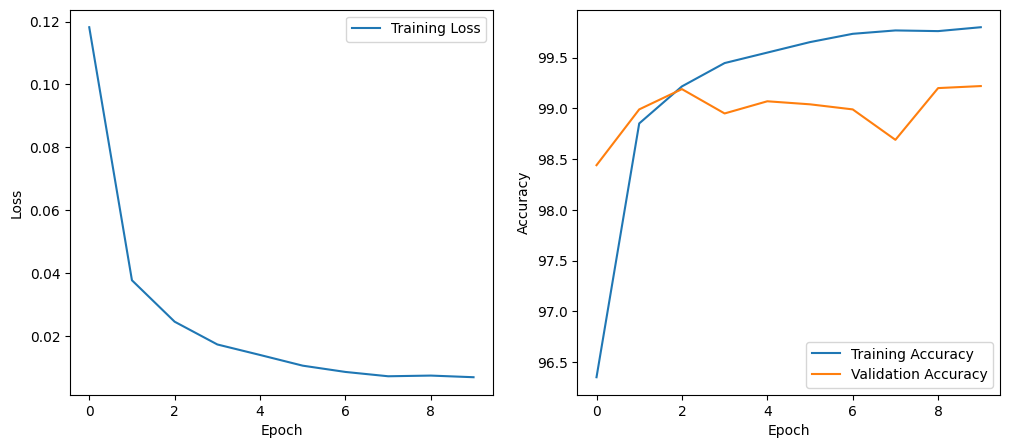

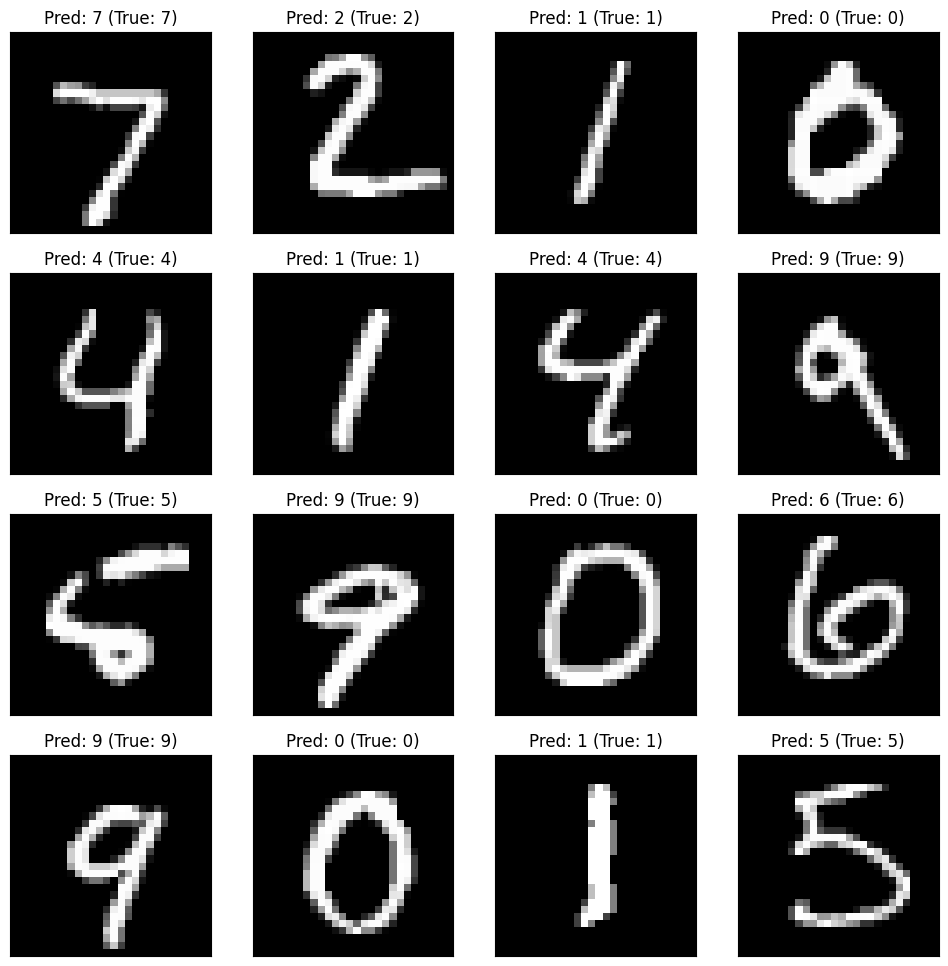

In [8]:

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot some predictions
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = outputs.max(1)

fig = plt.figure(figsize=(12, 12))
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Pred: {predicted[idx].item()} (True: {labels[idx].item()})')

plt.show()



### Save Model Weights

In [9]:
# Save the model weights
torch.save(model.state_dict(), 'vgg2layer_mnist.pth')